# Chunkfile Example

Examples on how to work with 'chunkfiles' using the `ratschlab-common` library.

It can be very useful to split up large dataframes into smaller files (chunks), s.t. they fit comfortably into memory and can be processed in parallel. It may be straightforward to do so in many cases, but
sometimes, groups of records should be processed together but independently of other records (e.g. data belong to a patient). 

One approach could be to make a separate file for each group. However, this may result into many small files which significantly degrades I/O and compression performance and potentially creates issues with the underlying file system. 

The `ratschlab-common` library provides support for working with chunkfiles where certain records should stay together in one file.

In [1]:
import dask.dataframe
import glob
import os
from pathlib import Path
import pandas as pd
import shutil
import tempfile
import distributed
import numpy as np

import ratschlab_common
from ratschlab_common.io.dataframe_formats import ParquetDataFrameFormat

In [2]:
temp_dir = tempfile.TemporaryDirectory()
data_dir = Path(temp_dir.name, 'chunkfile_examples')

fake_data_dir = Path(data_dir, 'fake_data')
repartitioned_data_dir = Path(data_dir, 'repartitioned_data')

# TODO: this should also work with hdf5. There are however some concurrency issues to be resolved.
data_format = ParquetDataFrameFormat()

## Generating Fake Data

In order to have some data for example purposes, we are going to generate some fake data. These consists of records having a patient id associated. 
The records are written out to files representing the partitions. Note, that by construction data having the same patient id end up in the same partition.

In [3]:
n_partitions = 10 # number of chunks
records = int(1e5) # records per partition/chunk
data_cols = 5 # number of columns besides patientid column

partition_key = 'patientid'

In [4]:
def recreate(path):
    if path.exists():
        shutil.rmtree(path)
    path.mkdir(parents=True)

In [5]:
recreate(fake_data_dir)

for i in range(n_partitions):
    patientids = np.sort(np.random.randint(i*100, (i+1)*100, records))
    
    cols = { partition_key : patientids }
    for c in range(data_cols):
        cols['col{}'.format(c)] = np.random.rand(records)
        
    df_part = pd.DataFrame(cols)
    
    partition_path = Path(fake_data_dir, 'partition-{}.{}'.format(i, data_format.format_extension()))
    
    data_format.write_df(df_part, partition_path)

In [6]:
!ls -la $fake_data_dir

total 110960
drwxr-xr-x  12 marc  staff      384 May 16 10:50 .
drwxr-xr-x   3 marc  staff       96 May 16 10:50 ..
-rw-r--r--   1 marc  staff  5680494 May 16 10:50 partition-0.parquet
-rw-r--r--   1 marc  staff  5680498 May 16 10:50 partition-1.parquet
-rw-r--r--   1 marc  staff  5680499 May 16 10:50 partition-2.parquet
-rw-r--r--   1 marc  staff  5680502 May 16 10:50 partition-3.parquet
-rw-r--r--   1 marc  staff  5680494 May 16 10:50 partition-4.parquet
-rw-r--r--   1 marc  staff  5680500 May 16 10:50 partition-5.parquet
-rw-r--r--   1 marc  staff  5680496 May 16 10:50 partition-6.parquet
-rw-r--r--   1 marc  staff  5680504 May 16 10:50 partition-7.parquet
-rw-r--r--   1 marc  staff  5680494 May 16 10:50 partition-8.parquet
-rw-r--r--   1 marc  staff  5680498 May 16 10:50 partition-9.parquet


## Repartition

Let's assume that we realize that the partitions (chunkfiles) are too big or to small. For example, some chunks don't fit easily into memory or there are many smallish files.

The code below copies the data and repartitiones the records s.t. that we have 20 approximately equally sized partitions and also s.t. the data of the same patients remains in the same file.

The repartitioning is done using `dask` (http://dask.pydata.org). In the call below, only the computing graph is returned, the actual computation is done later using an appropriate scheduler. Note, while creating the computation graph, we need to go through all files to generate the set of partition keys.

In [7]:
from ratschlab_common.io.chunks import repartition_dataframes

g = repartition_dataframes.repartition_directory(fake_data_dir, repartitioned_data_dir, 20, partition_key, data_format)
type(g) # only the computation graph!

dask.delayed.Delayed

Below the computing graph which is executed by dask. Every node corresponds to some python function where incoming edges denote the arguments.

We can see, that in this case, every input partition gets split up into two new partition, which is expected.

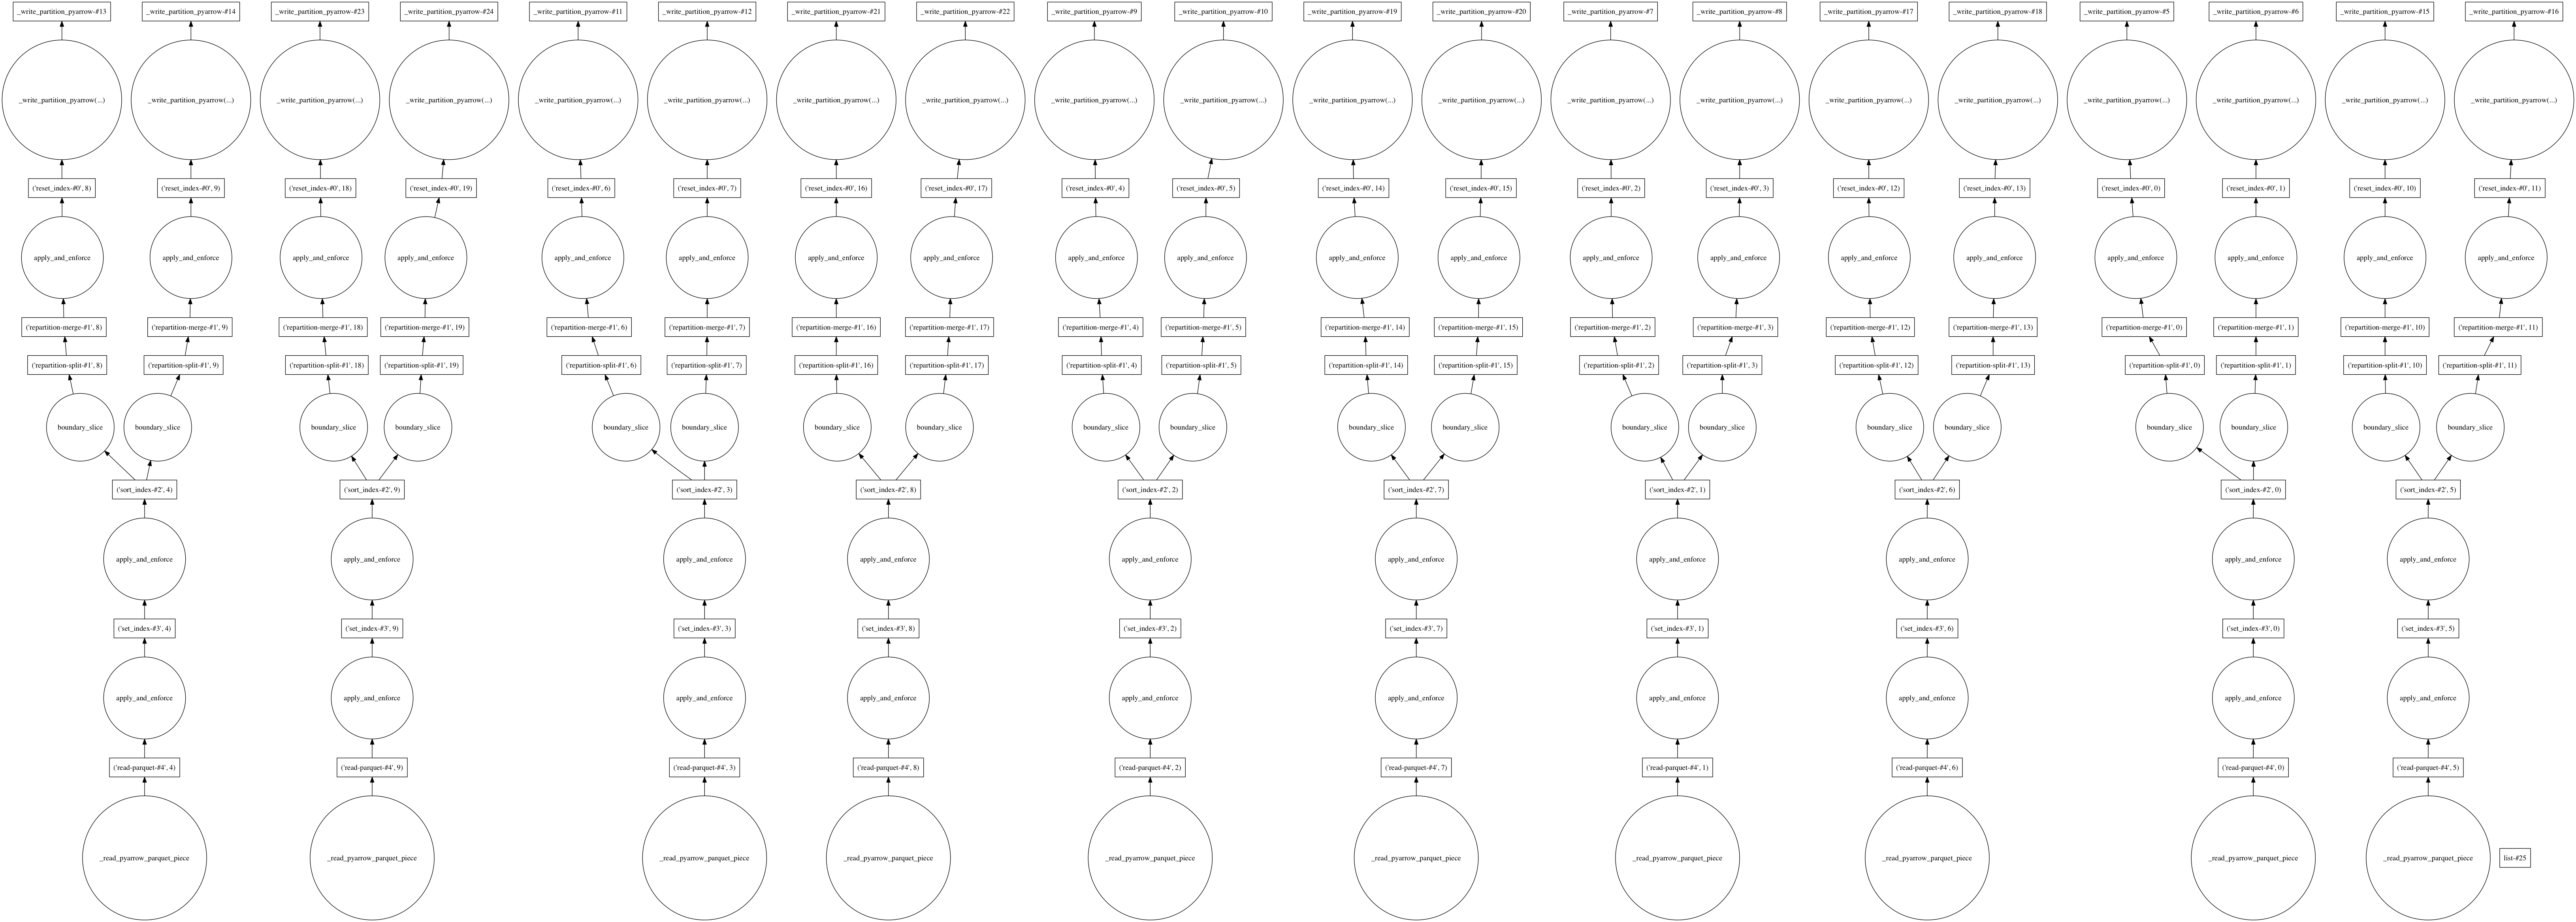

In [8]:
# requires `conda install python-graphviz` 

g.visualize('/tmp/chunkfile_computation_graph.png', optimize_graph=True)

Various dask schedulers could be chosen to perform the computation on the above graph, including a distributed one across several machines on a cluster. See http://dask.pydata.org/en/latest/scheduler-overview.html for an overview.

Below, the graph is computed using a "LocalCluster" using two processes on the local machine.

In [9]:
# doing the actual work now.
recreate(repartitioned_data_dir)

with distributed.LocalCluster(2):
    g.compute()

In [10]:
!ls -la $repartitioned_data_dir

total 97880
drwxr-xr-x  23 marc  staff      736 May 16 10:50 .
drwxr-xr-x   4 marc  staff      128 May 16 10:50 ..
-rw-r--r--   1 marc  staff      911 May 16 10:50 _common_metadata
-rw-r--r--   1 marc  staff  2502127 May 16 10:50 part.0.parquet
-rw-r--r--   1 marc  staff  2504929 May 16 10:50 part.1.parquet
-rw-r--r--   1 marc  staff  2493644 May 16 10:50 part.10.parquet
-rw-r--r--   1 marc  staff  2513407 May 16 10:50 part.11.parquet
-rw-r--r--   1 marc  staff  2494644 May 16 10:50 part.12.parquet
-rw-r--r--   1 marc  staff  2512407 May 16 10:50 part.13.parquet
-rw-r--r--   1 marc  staff  2535774 May 16 10:50 part.14.parquet
-rw-r--r--   1 marc  staff  2471279 May 16 10:50 part.15.parquet
-rw-r--r--   1 marc  staff  2498489 May 16 10:50 part.16.parquet
-rw-r--r--   1 marc  staff  2508571 May 16 10:50 part.17.parquet
-rw-r--r--   1 marc  staff  2495362 May 16 10:50 part.18.parquet
-rw-r--r--   1 marc  staff  2511689 May 16 10:50 part.19.parquet
-rw-r--r--   1 marc  staff  2496844 May 1

## Indexing Data Dir

Assume, we'd like to quickly access the data given a patient id. In order to pick the right file, some indexing needs to be done first

In [11]:
from ratschlab_common.io.chunks import chunk_indexing

index_file_path = chunk_indexing.index_chunkfiles(repartitioned_data_dir, partition_key, data_format)
index_file_path

'/var/folders/ry/d9fpyr5d21xgbjyrl084ssqh0000gn/T/tmpwl2g7n_0/chunkfile_examples/repartitioned_data/_patientid_index.json'

In [12]:
# reloading the index
file_dict = chunk_indexing.load_chunkfile_index(index_file_path)    

In this example, the entire file gets loaded into memory, which could be seen as a waste. But random access is considered only a secondary access pattern, e.g. during exploratory work and debugging

In [13]:
patientid = 501

file_path = Path(repartitioned_data_dir, file_dict[str(patientid)])

print('Reading patient {} from {}'.format(patientid, file_path))

(data_format.
  read_df(file_path).
  query('{} == {}'.format(partition_key, patientid)).
  head())

Reading patient 501 from /var/folders/ry/d9fpyr5d21xgbjyrl084ssqh0000gn/T/tmpwl2g7n_0/chunkfile_examples/repartitioned_data/part.10.parquet


,patientid,col0,col1,col2,col3,col4
1020,501,0.614564,0.941452,0.601976,0.830858,0.933256
1021,501,0.189175,0.909215,0.336790,0.666038,0.565775
1022,501,0.749842,0.407937,0.385177,0.190969,0.955898
1023,501,0.720621,0.978373,0.402581,0.222198,0.649627
1024,501,0.467643,0.821308,0.945484,0.794556,0.210639


In [14]:
temp_dir.cleanup() # cleaning up temporary files